## Libraries

In [1]:
import json
import pandas as pd
import os

## Config

In [ ]:
# Load the config file
with open('../config/config.json', 'r') as f:
    config = json.load(f)

file_path = config["data_loc"]
file_name = "QTL_text.json"
final_path = os.path.join(file_path, file_name) 

## Import Dataset

In [3]:
# Load json file
df = pd.read_json(final_path)
print(f"Shape of the original dataset: {df.shape}", "\n")

df.head()

Shape of the original dataset: (11278, 5) 



,PMID,Journal,Title,Abstract,Category
0,17179536,J Anim Sci. 2007 Jan;85(1):22-30.,Variance component analysis of quantitative tr...,"In a previous study, QTL for carcass compositi...",1
1,17177700,J Anim Breed Genet. 2006 Dec;123(6):414-8.,"Single nucleotide polymorphism identification,...",Pituitary adenylate cyclase-activating polypep...,0
2,17129674,Vet Parasitol. 2007 Apr 10;145(1-2):2-10. Epub...,Genetic resistance to Sarcocystis miescheriana...,Clinical and parasitological traits of Sarcocy...,0
3,17121599,Anim Genet. 2006 Dec;37(6):543-53.,Results of a whole-genome quantitative trait l...,A whole-genome quantitative trait locus (QTL) ...,1
4,17057239,Genetics. 2006 Dec;174(4):2119-27. Epub 2006 O...,Unexpected high polymorphism at the FABP4 gene...,Fatty acid bing protein 4 (FABP4) plays a key ...,0


## Pre-processing and other requirements

In [4]:
# "In this project, you will need to use "Abstract" and "Category", and you can ignore the other fields."
df_processed = df[['Abstract', 'Category']]
print(f"Shape before filtering: {df_processed.shape}", "\n")

# "In this project, you need to ignore papers in Category ‘0’."
df_processed = df_processed[df_processed['Category'] == 1]
print(f"Shape after filtering: {df_processed.shape}", "\n")

df_processed.head()

Shape before filtering: (11278, 2) 

Shape after filtering: (1007, 2) 



,Abstract,Category
0,"In a previous study, QTL for carcass compositi...",1
3,A whole-genome quantitative trait locus (QTL) ...,1
5,A partial genome scan using microsatellite mar...,1
7,BACKGROUND: The rate of pubertal development a...,1
10,"Previously, quantitative trait loci (QTL) for ...",1


### Tokenization of Sentences

In [5]:
import spacy
nlp_spacy = spacy.load("en_core_web_sm")

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/gabrielvictorgomesferr
[nltk_data]     eira/opt/anaconda3/envs/nlp_env/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/gabrielvictorgomes
[nltk_data]     ferreira/opt/anaconda3/envs/nlp_env/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# Using split
df_processed['abstract_split'] = df_processed['Abstract'].apply(lambda token: [token.lower() for token in token.split() if token not in stop_words])

# Using spacy
df_processed['abstract_spacy'] = df_processed['Abstract'].apply(lambda token: [token.text.lower() for token in nlp_spacy(token) if not token.is_stop])

# Using nltk
df_processed['abstract_nltk'] = df_processed['Abstract'].apply(lambda token: [token.lower() for token in word_tokenize(token) if token not in stop_words])

df_processed.head()

,Abstract,Category,abstract_split,abstract_spacy,abstract_nltk
0,"In a previous study, QTL for carcass compositi...",1,"[in, previous, study,, qtl, carcass, compositi...","[previous, study, ,, qtl, carcass, composition...","[in, previous, study, ,, qtl, carcass, composi..."
3,A whole-genome quantitative trait locus (QTL) ...,1,"[a, whole-genome, quantitative, trait, locus, ...","[-, genome, quantitative, trait, locus, (, qtl...","[a, whole-genome, quantitative, trait, locus, ..."
5,A partial genome scan using microsatellite mar...,1,"[a, partial, genome, scan, using, microsatelli...","[partial, genome, scan, microsatellite, marker...","[a, partial, genome, scan, using, microsatelli..."
7,BACKGROUND: The rate of pubertal development a...,1,"[background:, the, rate, pubertal, development...","[background, :, rate, pubertal, development, w...","[background, :, the, rate, pubertal, developme..."
10,"Previously, quantitative trait loci (QTL) for ...",1,"[previously,, quantitative, trait, loci, (qtl)...","[previously, ,, quantitative, trait, loci, (, ...","[previously, ,, quantitative, trait, loci, (, ..."


## Task 1 - WordCloud Visualization

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Frequency Base

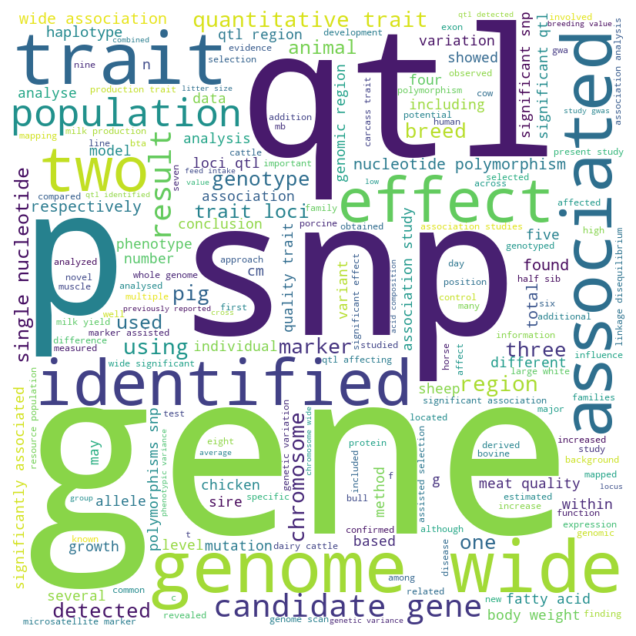

In [8]:
# Define input text
input_text = " ".join([" ".join(words) for words in df_processed['abstract_nltk']])

# Define word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(input_text)

# Display
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### TD-IDF Base

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

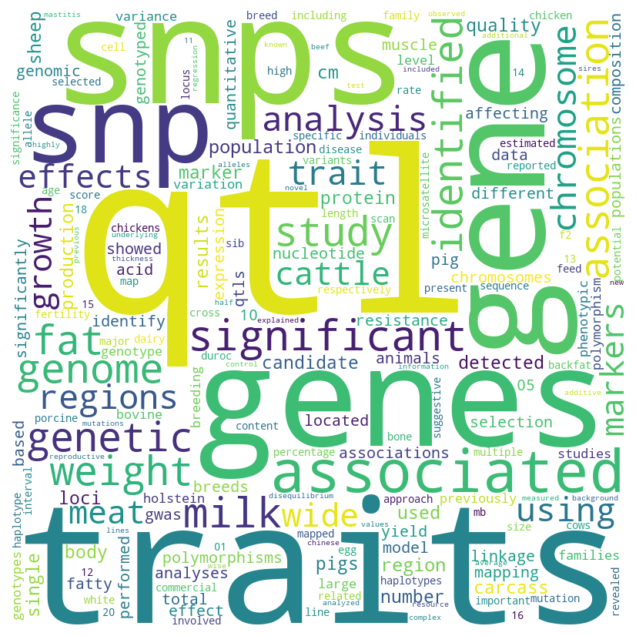

In [10]:
# Compute TF-IDF
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vec.fit_transform(df_processed['abstract_nltk'].apply(lambda token: " ".join(token)))
tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
tfidf_word = dict(zip(tfidf_vec.get_feature_names_out(), tfidf_scores))

# Define word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(tfidf_word)

# Display
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# Top TF-IDF words
top_words = sorted(tfidf_word.items(), key=lambda x: x[1], reverse=True)[:10]
for word, score in top_words:
    print(f"{word}: {score:.4f}")

qtl: 0.0621
traits: 0.0400
snps: 0.0306
genes: 0.0262
gene: 0.0260
snp: 0.0258
associated: 0.0256
significant: 0.0242
milk: 0.0237
genome: 0.0228


## Task 2 - Train a Word2Vec model on this corpus

In [11]:
import gensim

abstract_nltk = df_processed['abstract_nltk']

# Train Word2Vec model
word2vec_model = gensim.models.Word2Vec(
    vector_size=100,
    window=5,
    min_count=10)

word2vec_model.build_vocab(abstract_nltk)

word2vec_model.train(abstract_nltk, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

(670780, 1016215)

In [ ]:
word2vec_model.wv.most_similar("mapped").tolist()

AttributeError: 'list' object has no attribute 'tolist'

In [27]:
# Check similar words
for word in top_words:
    print(word2vec_model.wv.most_similar(word[0]))

[('qtls', 0.961912214756012), ('mapped', 0.9084188938140869), ('detected', 0.8635432124137878), ('previously', 0.8479742407798767), ('loci', 0.8194685578346252), ('locus', 0.8075971007347107), ('identified', 0.8071075081825256), ('chromosomal', 0.8027009963989258), ('overlapped', 0.8022022247314453), ('reported', 0.792787492275238)]
[('growth', 0.925348162651062), ('carcass', 0.9028927087783813), ('fertility', 0.880872368812561), ('fatness', 0.8805666565895081), ('eggshell', 0.8797847032546997), ('bone', 0.8619251847267151), ('production', 0.8581082224845886), ('related', 0.8496228456497192), ('meat', 0.8484787344932556), ('economically', 0.8430574536323547)]
[('associations', 0.9271158576011658), ('snp', 0.8713247179985046), ('seven', 0.8552137613296509), ('four', 0.8516391515731812), ('five', 0.8461287617683411), ('intron', 0.8246538639068604), ('single-nucleotide', 0.8243856430053711), ('three', 0.8181261420249939), ('found', 0.816311776638031), ('nucleotide', 0.813818633556366)]
[(

In [ ]:
!pip install ace_tools

In [36]:
for word in top_words:
    similar_words = word2vec_model.wv.most_similar(word[0], topn=10)
    print(f"\n🔹 **{word[0]}** → {', '.join([w[0] for w in similar_words])}")



🔹 **qtl** → qtls, mapped, detected, previously, loci, locus, identified, chromosomal, overlapped, reported

🔹 **traits** → growth, carcass, fertility, fatness, eggshell, bone, production, related, meat, economically

🔹 **snps** → associations, snp, seven, four, five, intron, single-nucleotide, three, found, nucleotide

🔹 **genes** → candidate, positional, several, plausible, involved, functional, potential, known, reported, harboring

🔹 **gene** → candidate, positional, coding, genes, plausible, novel, within, promoter, porcine, causal

🔹 **snp** → polymorphism, snps, haplotypes, single-nucleotide, nucleotide, conformational, revealed, single, intron, three

🔹 **associated** → significantly, receptor, also, found, near, factor, bta14, close, scd, one

🔹 **significant** → suggestive, found, associations, significance, level, detected, chromosome-wide, genome-wise, chromosome-wise, threshold

🔹 **milk** → chl, summer, fatty, acids, composition, yield, deposition, acid, protein, fat

🔹 *